<a href="https://colab.research.google.com/github/lightofhappiness/UAS_BasisData/blob/main/BigDataAnalysis_UAS(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.functions import col, to_date, year, month
from pyspark.sql.functions import unix_timestamp, date_format
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from prophet import Prophet

In [ ]:
import os

file_url = "https://data.transportation.gov/api/views/keg4-3bc2/rows.csv?accessType=DOWNLOAD"
local_filename = "Border_Crossing_Entry_Data.csv"

if not os.path.exists(local_filename):
  print(f"File '{local_filename}' not found. Downloading...")

  !wget -q -O '{local_filename}' '{file_url}'
  print(f"Download complete. File saved as '{local_filename}'.")
else:
  print(f"File '{local_filename}' already exists. Skipping download.")


df = pd.read_csv(local_filename)


File 'Border_Crossing_Entry_Data.csv' not found. Downloading...
Download complete. File saved as 'Border_Crossing_Entry_Data.csv'.


In [ ]:
# Inisialisasi Spark
def init_spark():
    return SparkSession.builder.appName("BorderCrossingPrediction").getOrCreate()

In [ ]:
# # Load dan Preprocessing Data
# def load_data(spark, file_path):
#     df = spark.read.csv(file_path, header=True, inferSchema=True)
#     df_cleaned = df.select(
#         to_date(col("Date"), "MM/dd/yyyy").alias("Date"),
#         col("Border"),
#         col("Value")
#     ).dropna()

#     df_monthly = df_cleaned.withColumn("Year", year(col("Date")))\
#                            .withColumn("Month", month(col("Date")))\
#                            .groupBy("Year", "Month")\
#                            .agg({"Value": "sum"})\
#                            .withColumnRenamed("sum(Value)", "TotalCrossings")

#     df_final = df_monthly.withColumn("TimeIndex", col("Year") * 12 + col("Month"))
#     return df_final

def load_data(Bolt, file_path):
    df = spark.read.csv(file_path, header=True, inferSchema=True)

    # Debugging awal
    print(f"Jumlah baris dalam df (setelah load CSV): {df.count()}")
    df.show(5)

    # Konversi format Date yang sesuai
    df_cleaned = df.withColumn(
        "Date", date_format(unix_timestamp(col("Date"), "MMM yyyy").cast("timestamp"), "yyyy-MM-dd")
    ).select(
        col("Date"),
        col("Border"),
        col("Value")
    ).dropna()

    print(f"Jumlah baris dalam df_cleaned (setelah konversi tanggal & dropna): {df_cleaned.count()}")
    df_cleaned.show(5)

    # Agregasi berdasarkan bulan
    df_monthly = df_cleaned.withColumn("Year", year(col("Date")))\
                           .withColumn("Month", month(col("Date")))\
                           .groupBy("Year", "Month")\
                           .agg({"Value": "sum"})\
                           .withColumnRenamed("sum(Value)", "TotalCrossings")

    print(f"Jumlah baris dalam df_monthly (setelah agregasi): {df_monthly.count()}")
    df_monthly.show(5)

    # Menambahkan TimeIndex untuk training
    df_final = df_monthly.withColumn("TimeIndex", col("Year") * 12 + col("Month"))

    print(f"Jumlah baris dalam df_final (setelah TimeIndex): {df_final.count()}")
    df_final.show(5)

    return df_final

In [ ]:
# Persiapan Fitur untuk Machine Learning
def prepare_features(df):
    assembler = VectorAssembler(inputCols=["TimeIndex"], outputCol="features")
    df_ml = assembler.transform(df).select("features", col("TotalCrossings").alias("label"))
    return df_ml

In [ ]:
# Training Model Machine Learning (Linear Regression)
def train_model(df_ml):
    train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)
    lr = LinearRegression(featuresCol="features", labelCol="label")
    lr_model = lr.fit(train_data)

    # Evaluasi Model
    predictions = lr_model.transform(test_data)
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    return lr_model

In [ ]:
# Prediksi Masa Depan
def predict_future(spark, lr_model):
    future_dates = [(2025, m) for m in range(1, 13)]
    future_df = spark.createDataFrame([(y * 12 + m,) for y, m in future_dates], ["TimeIndex"])

    assembler = VectorAssembler(inputCols=["TimeIndex"], outputCol="features")
    future_df = assembler.transform(future_df)

    future_predictions = lr_model.transform(future_df)
    return future_predictions.select("TimeIndex", "prediction")

# def predict_future(spark, lr_model):
#     future_dates = [(2025, m) for m in range(1, 13)]
#     future_df = spark.createDataFrame([(y * 12 + m,) for y, m in future_dates], ["TimeIndex"])

#     assembler = VectorAssembler(inputCols=["TimeIndex"], outputCol="features")
#     future_df = assembler.transform(future_df)

#     future_predictions = lr_model.transform(future_df).select("TimeIndex", "prediction")

#     # Konversi ke Pandas untuk visualisasi
#     return future_predictions.toPandas()

In [ ]:
# df.agg(min("Year").alias("MinYear"), max("Year").alias("MaxYear")).show()
df


,Port Name,State,Port Code,Border,Date,Measure,Value,Latitude,Longitude,Point
0,Jackman,Maine,104,US-Canada Border,Jan 2024,Trucks,6556,45.806,-70.397,POINT (-70.396722 45.805661)
1,Porthill,Idaho,3308,US-Canada Border,Apr 2024,Trucks,98,49.000,-116.499,POINT (-116.49925 48.999861)
2,San Luis,Arizona,2608,US-Mexico Border,Apr 2024,Buses,10,32.485,-114.782,POINT (-114.7822222 32.485)
3,Willow Creek,Montana,3325,US-Canada Border,Jan 2024,Pedestrians,2,49.000,-109.731,POINT (-109.731333 48.999972)
4,Warroad,Minnesota,3423,US-Canada Border,Jan 2024,Personal Vehicle Passengers,9266,48.999,-95.377,POINT (-95.376555 48.999)
...,...,...,...,...,...,...,...,...,...,...
399401,Opheim,Montana,3317,US-Canada Border,Feb 2025,Truck Containers Empty,9,49.000,-106.378,POINT (-106.377583 48.999527)
399402,Lukeville,Arizona,2602,US-Mexico Border,Feb 2025,Personal Vehicles,22385,31.880,-112.817,POINT (-112.817077 31.880195)
399403,Vanceboro,Maine,105,US-Canada Border,Feb 2025,Personal Vehicle Passengers,797,45.569,-67.429,POINT (-67.428541 45.568761)
399404,Fort Fairfield,Maine,107,US-Canada Border,Feb 2025,Truck Containers Loaded,71,46.765,-67.789,POINT (-67.789471 46.765323)


In [ ]:
# Implementasi
if __name__ == "__main__":
    spark = init_spark()
    file_path = "/content/Border_Crossing_Entry_Data.csv"
    df = load_data(spark, file_path)
    df_ml = prepare_features(df)
    lr_model = train_model(df_ml)
    future_predictions = predict_future(spark, lr_model)
    future_predictions.show()

Jumlah baris dalam df (setelah load CSV): 400148
+------------+---------+---------+----------------+--------+--------------------+-----+--------+---------+--------------------+
|   Port Name|    State|Port Code|          Border|    Date|             Measure|Value|Latitude|Longitude|               Point|
+------------+---------+---------+----------------+--------+--------------------+-----+--------+---------+--------------------+
|     Jackman|    Maine|      104|US-Canada Border|Jan 2024|              Trucks| 6556|  45.806|  -70.397|POINT (-70.396722...|
|    Porthill|    Idaho|     3308|US-Canada Border|Apr 2024|              Trucks|   98|    49.0| -116.499|POINT (-116.49925...|
|    San Luis|  Arizona|     2608|US-Mexico Border|Apr 2024|               Buses|   10|  32.485| -114.782|POINT (-114.78222...|
|Willow Creek|  Montana|     3325|US-Canada Border|Jan 2024|         Pedestrians|    2|    49.0| -109.731|POINT (-109.73133...|
|     Warroad|Minnesota|     3423|US-Canada Border|Jan 

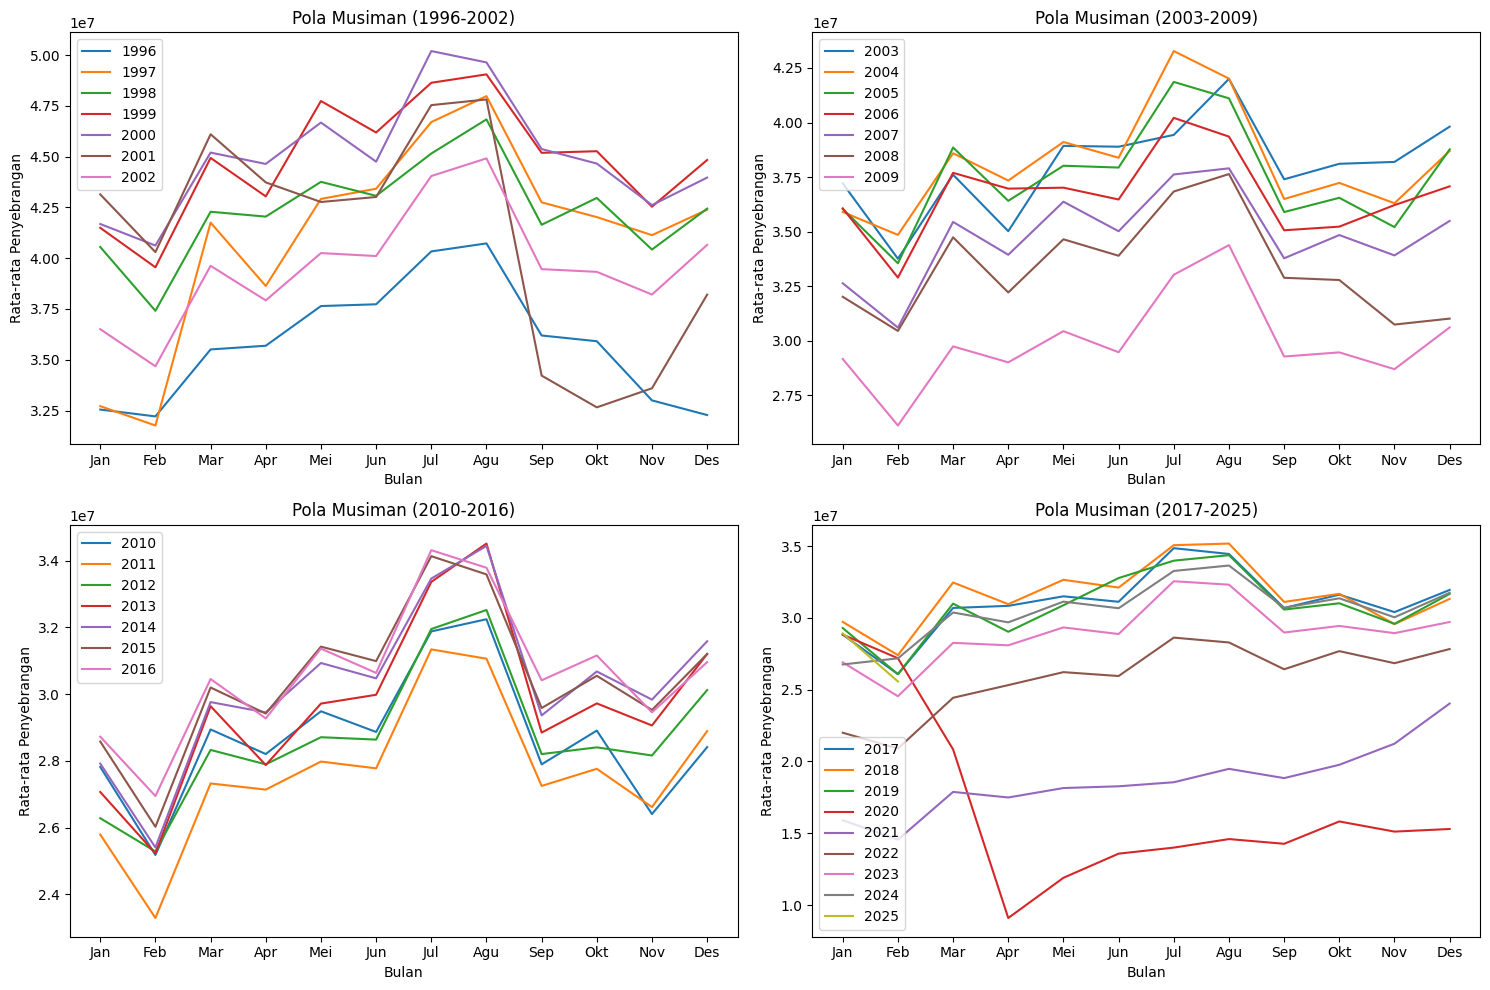

In [ ]:
# def plot_seasonal_pattern(df):
#     # Agregasi data berdasarkan bulan dan tahun
#     df_seasonal = df.groupBy("Year", "Month").agg(avg("TotalCrossings").alias("AvgCrossings"))

#     # Konversi ke Pandas untuk visualisasi
#     df_seasonal_pd = df_seasonal.toPandas().sort_values(by=["Year", "Month"])

#     # Plot
#     plt.figure(figsize=(12, 6))
#     sns.lineplot(data=df_seasonal_pd, x="Month", y="AvgCrossings", hue="Year", marker="o")

#     plt.xlabel("Bulan")
#     plt.ylabel("Rata-rata Total Penyebrangan")
#     plt.title("Analisis Pola Musiman Penyebrangan Berdasarkan Tahun")
#     plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "Mei", "Jun", "Jul", "Agu", "Sep", "Okt", "Nov", "Des"])
#     plt.legend(title="Tahun", bbox_to_anchor=(1.05, 1), loc="upper left")
#     plt.grid()

#     plt.show()

# # Konversi DataFrame Spark ke Pandas
# df_pandas = df.groupBy("Year", "Month")\
#               .agg({"TotalCrossings": "avg"})\
#               .withColumnRenamed("avg(TotalCrossings)", "AvgCrossings")\
#               .orderBy("Year", "Month")\
#               .toPandas()

# # Membagi data menjadi 4 kelompok
# bins = [(1996, 2002), (2003, 2009), (2010, 2016), (2017, 2025)]

# plt.figure(figsize=(15, 10))

# for i, (start, end) in enumerate(bins, 1):
#     subset = df_pandas[(df_pandas["Year"] >= start) & (df_pandas["Year"] <= end)]

#     plt.subplot(2, 2, i)  # Buat grid 2x2
#     for year in range(start, end + 1):
#         yearly_data = subset[subset["Year"] == year]
#         plt.plot(yearly_data["Month"], yearly_data["AvgCrossings"], label=str(year))

#     plt.xlabel("Bulan")
#     plt.ylabel("Rata-rata Penyebrangan")
#     plt.title(f"Pola Musiman ({start}-{end})")
#     plt.legend()
#     plt.xticks(range(1, 13))  # Pastikan label bulan dari 1 sampai 12

# plt.tight_layout()
# plt.show()

def plot_seasonal_trends(df):
    # Konversi DataFrame Spark ke Pandas
    df_pandas = df.groupBy("Year", "Month")\
                  .agg({"TotalCrossings": "avg"})\
                  .withColumnRenamed("avg(TotalCrossings)", "AvgCrossings")\
                  .orderBy("Year", "Month")\
                  .toPandas()

    # Membagi data menjadi 4 kelompok
    bins = [(1996, 2002), (2003, 2009), (2010, 2016), (2017, 2025)]

    plt.figure(figsize=(15, 10))

    month_labels = ["Jan", "Feb", "Mar", "Apr", "Mei", "Jun", "Jul", "Agu", "Sep", "Okt", "Nov", "Des"]

    for i, (start, end) in enumerate(bins, 1):
        subset = df_pandas[(df_pandas["Year"] >= start) & (df_pandas["Year"] <= end)]

        plt.subplot(2, 2, i)  # Buat grid 2x2
        for year in range(start, end + 1):
            yearly_data = subset[subset["Year"] == year]
            plt.plot(yearly_data["Month"], yearly_data["AvgCrossings"], label=str(year))

        plt.xlabel("Bulan")
        plt.ylabel("Rata-rata Penyebrangan")
        plt.title(f"Pola Musiman ({start}-{end})")
        plt.legend()
        plt.xticks(range(1, 13), labels=month_labels)  # Menampilkan label bulan

    plt.tight_layout()
    plt.show()

plot_seasonal_trends(df)

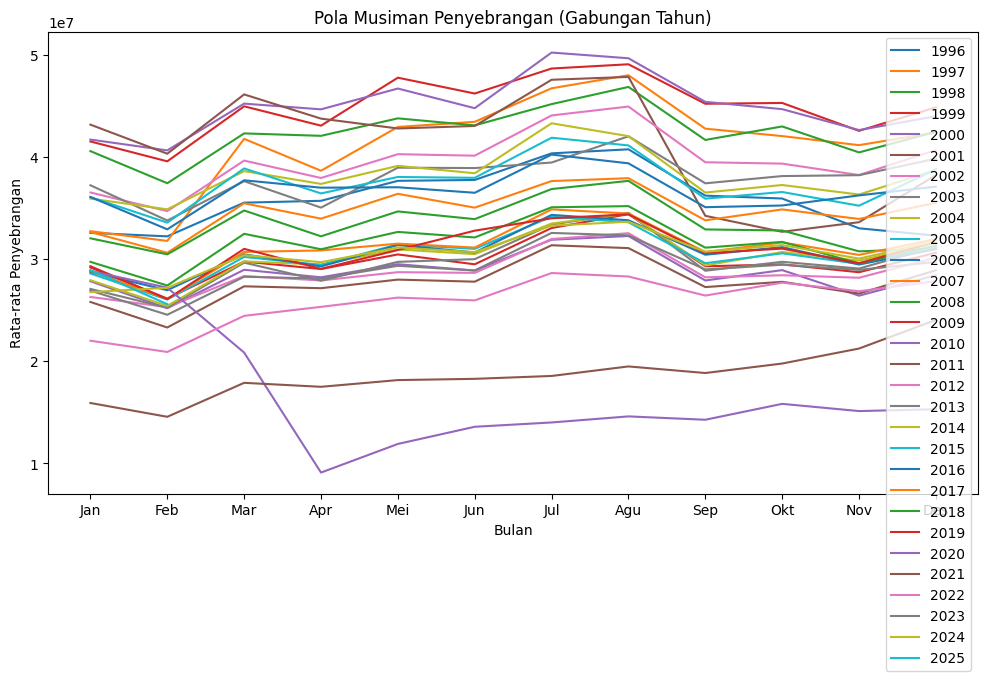

In [ ]:
def plot_seasonal_trends_all_year(df):
    # Konversi DataFrame Spark ke Pandas
    df_pandas = df.groupBy("Year", "Month")\
                  .agg({"TotalCrossings": "avg"})\
                  .withColumnRenamed("avg(TotalCrossings)", "AvgCrossings")\
                  .orderBy("Year", "Month")\
                  .toPandas()

    plt.figure(figsize=(12, 6))
    month_labels = ["Jan", "Feb", "Mar", "Apr", "Mei", "Jun", "Jul", "Agu", "Sep", "Okt", "Nov", "Des"]

    for year in sorted(df_pandas["Year"].unique()):
        yearly_data = df_pandas[df_pandas["Year"] == year]
        plt.plot(yearly_data["Month"], yearly_data["AvgCrossings"], label=str(year))

    plt.xlabel("Bulan")
    plt.ylabel("Rata-rata Penyebrangan")
    plt.title("Pola Musiman Penyebrangan (Gabungan Tahun)")
    plt.legend()
    plt.xticks(range(1, 13), labels=month_labels)  # Menampilkan label bulan

    # plt.tight_layout()
    plt.show()

plot_seasonal_trends_all_year(df)

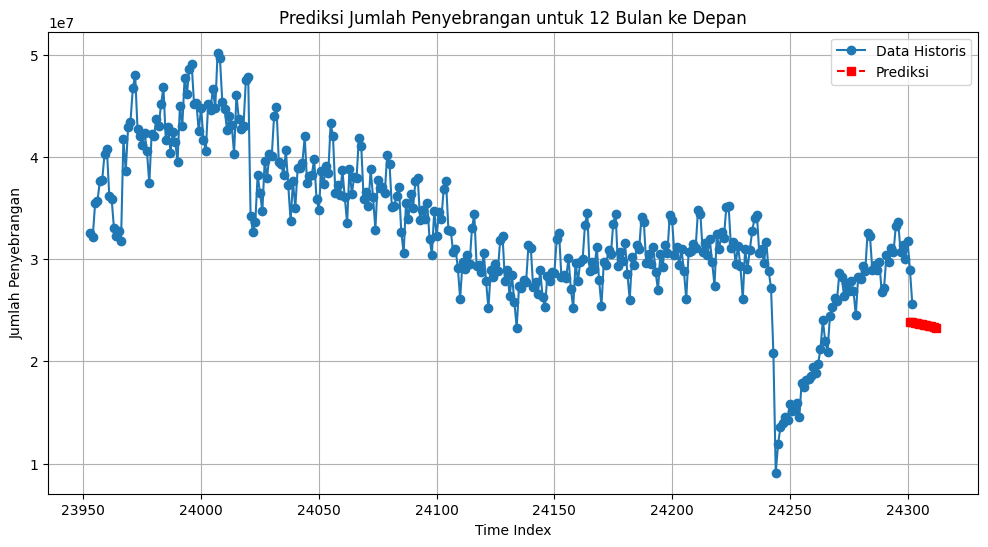

In [ ]:
# def plot_future_prediction(future_df):
#     # Konversi TimeIndex ke format Tahun-Bulan
#     future_df["Year"] = (future_df["TimeIndex"] // 12).astype(int)
#     future_df["Month"] = (future_df["TimeIndex"] % 12).astype(int)
#     future_df["Date"] = future_df["Year"].astype(str) + "-" + future_df["Month"].astype(str).apply(lambda x: x.zfill(2))

#     # Plot grafik
#     plt.figure(figsize=(10, 5))
#     plt.plot(future_df["Date"], future_df["prediction"], marker="o", linestyle="-", color="r", label="Prediksi")

#     plt.xlabel("Bulan")
#     plt.ylabel("Total Crossings")
#     plt.title("Prediksi Jumlah Penyebrangan Tahun 2025")
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.grid()

#     plt.show()

# # Panggil fungsi dengan hasil prediksi
# future_df = predict_future(spark, lr_model)
# plot_future_prediction(future_df)

def plot_predictions(df, future_predictions):
    # Konversi DataFrame Spark ke Pandas
    df_pandas = df.select("TimeIndex", "TotalCrossings").orderBy("TimeIndex").toPandas()
    future_pandas = future_predictions.select("TimeIndex", "prediction").orderBy("TimeIndex").toPandas()

    plt.figure(figsize=(12, 6))

    # Plot data historis
    plt.plot(df_pandas["TimeIndex"], df_pandas["TotalCrossings"], label="Data Historis", marker='o')

    # Plot data prediksi
    plt.plot(future_pandas["TimeIndex"], future_pandas["prediction"], label="Prediksi", linestyle='dashed', marker='s', color='red')

    plt.xlabel("Time Index")
    plt.ylabel("Jumlah Penyebrangan")
    plt.title("Prediksi Jumlah Penyebrangan untuk 12 Bulan ke Depan")
    plt.legend()
    plt.grid()

    plt.show()

plot_predictions(df, future_predictions)

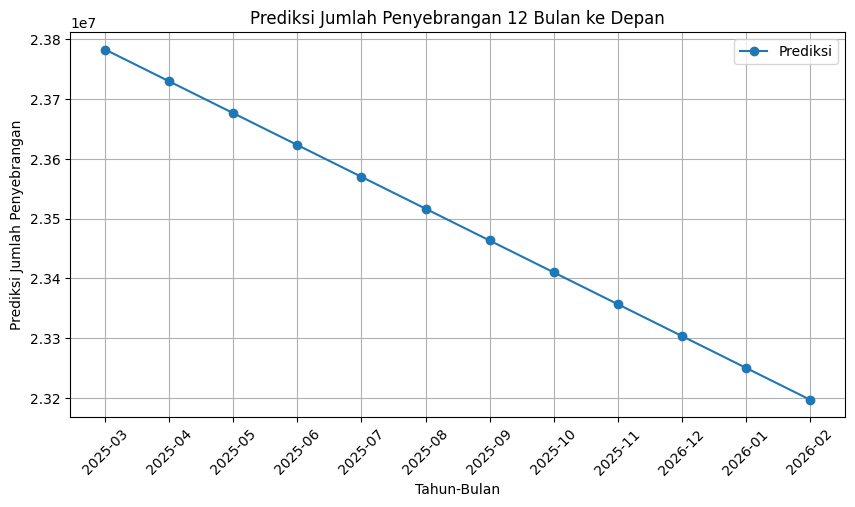

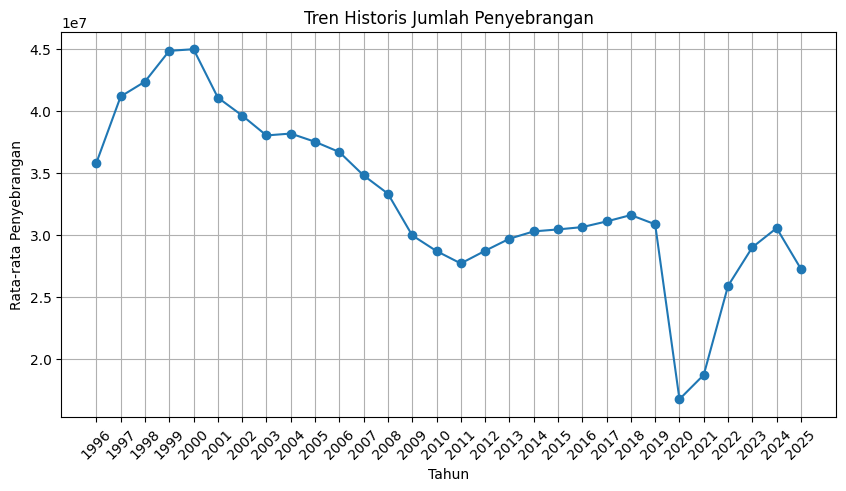

In [ ]:
# def train_model(df_ml):
#     lr = LinearRegression(featuresCol="features", labelCol="label")
#     lr_model = lr.fit(df_ml)
#     return lr_model

# def predict_future(spark, lr_model):
#     future_dates = [(2025, m) for m in range(3, 15)]  # Mulai dari Maret 2025 - Feb 2026
#     future_df = spark.createDataFrame([(y * 12 + m,) for y, m in future_dates], ["TimeIndex"])

#     assembler = VectorAssembler(inputCols=["TimeIndex"], outputCol="features")
#     future_df = assembler.transform(future_df)

#     future_predictions = lr_model.transform(future_df)
#     return future_predictions.select("TimeIndex", "prediction").toPandas()

def plot_future_predictions(future_predictions):
    plt.figure(figsize=(10, 5))

    # Konversi TimeIndex ke format Tahun-Bulan
    future_predictions["Year"] = future_predictions["TimeIndex"] // 12
    future_predictions["Month"] = (future_predictions["TimeIndex"] % 12)
    future_predictions["Month"] = future_predictions["Month"].replace(0, 12)
    future_predictions.sort_values(by="TimeIndex", inplace=True)

    # Plot data
    plt.plot(future_predictions["TimeIndex"], future_predictions["prediction"], marker='o', linestyle='-', label='Prediksi')
    plt.xlabel("Tahun-Bulan")
    plt.ylabel("Prediksi Jumlah Penyebrangan")
    plt.title("Prediksi Jumlah Penyebrangan 12 Bulan ke Depan")

    # Ganti TimeIndex jadi label Tahun-Bulan agar lebih jelas
    xticks_labels = [f"{int(y)}-{int(m):02d}" for y, m in zip(future_predictions["Year"], future_predictions["Month"])]
    plt.xticks(future_predictions["TimeIndex"], xticks_labels, rotation=45)

    plt.grid()
    plt.legend()
    plt.show()

# ini tren dari tahun ke tahun
def plot_historical_trend(df):
    df_pandas = df.select("Year", "TotalCrossings").groupBy("Year").avg("TotalCrossings").orderBy("Year").toPandas()

    plt.figure(figsize=(10, 5))
    plt.plot(df_pandas["Year"], df_pandas["avg(TotalCrossings)"], marker='o', linestyle='-')
    plt.xlabel("Tahun")
    plt.ylabel("Rata-rata Penyebrangan")
    plt.title("Tren Historis Jumlah Penyebrangan")
    plt.grid()

    # Menampilkan semua tahun di sumbu x
    plt.xticks(df_pandas["Year"], df_pandas["Year"], rotation=45)

    plt.show()

future_predictions = predict_future(spark, lr_model)
plot_future_predictions(future_predictions)

plot_historical_trend(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zip2zwf/zvsrl4oj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zip2zwf/5x5ud6dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68109', 'data', 'file=/tmp/tmp4zip2zwf/zvsrl4oj.json', 'init=/tmp/tmp4zip2zwf/5x5ud6dc.json', 'output', 'file=/tmp/tmp4zip2zwf/prophet_modelj64e9p49/prophet_model-20250401123431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-53-d7728d6ea3cc>:12: Futu

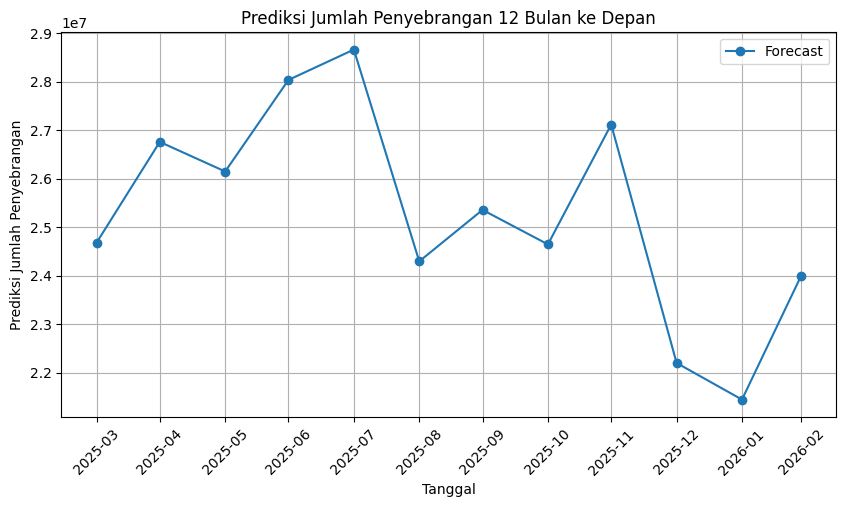

In [ ]:
# ini pake prophet

def train_prophet(df_pandas):
    df_pandas = df_pandas.rename(columns={"TotalCrossings": "y"})
    df_pandas["ds"] = df_pandas.index

    model = Prophet()
    model.fit(df_pandas)
    return model

def predict_future_prophet(model, last_date, periods=12):
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='M')
    future_df = pd.DataFrame({"ds": future_dates})
    forecast = model.predict(future_df)
    return forecast[['ds', 'yhat']]

def plot_future_predictions(future_predictions):
    plt.figure(figsize=(10, 5))
    plt.plot(future_predictions['ds'], future_predictions['yhat'], marker='o', linestyle='-', label='Forecast')
    plt.xlabel("Tanggal")
    plt.ylabel("Prediksi Jumlah Penyebrangan")
    plt.title("Prediksi Jumlah Penyebrangan 12 Bulan ke Depan")
    plt.xticks(future_predictions['ds'], future_predictions['ds'].dt.strftime('%Y-%m'), rotation=45)
    plt.grid()
    plt.legend()
    plt.show()

df_pandas = df.toPandas()
df_pandas['Date'] = pd.to_datetime(df_pandas[['Year', 'Month']].assign(DAY=1))
df_pandas.set_index('Date', inplace=True)
df_pandas.sort_index(inplace=True)

model = train_prophet(df_pandas)
last_date = df_pandas.index[-1]
future_predictions = predict_future_prophet(model, last_date, periods=12)
plot_future_predictions(future_predictions)

Detected Anomalies (Z-score):
            TotalCrossings   z_score  is_anomaly
Date                                            
2020-04-01         9100075 -3.309853        True


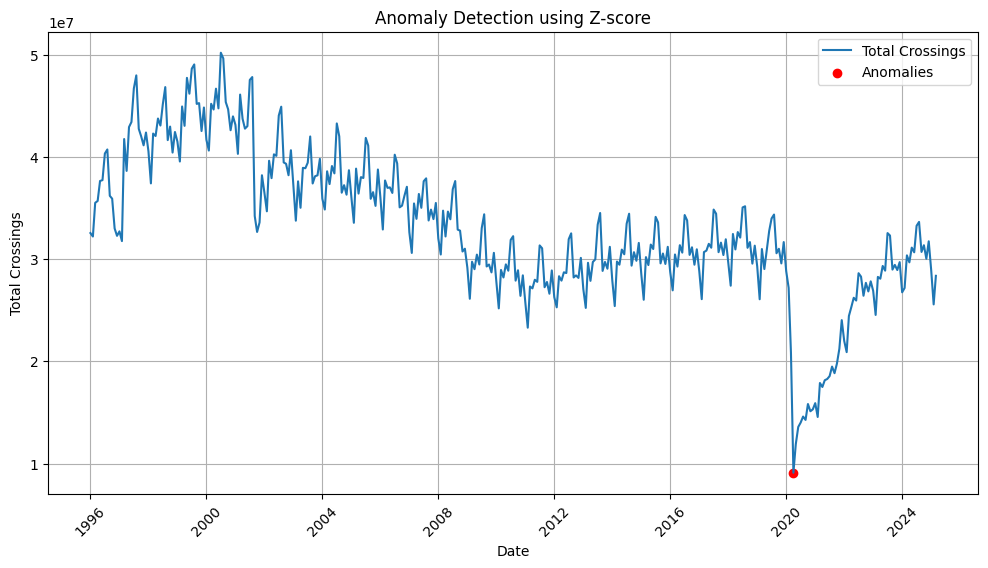

In [ ]:
# prompt: anomaly z score

def detect_anomalies_zscore(df_pandas, column, threshold=3):
    """
    Detects anomalies in a pandas DataFrame column using the Z-score method.

    Args:
        df_pandas (pd.DataFrame): The input pandas DataFrame.
        column (str): The name of the column to analyze for anomalies.
        threshold (float): The Z-score threshold above which a data point is considered an anomaly.

    Returns:
        pd.DataFrame: The input DataFrame with an additional 'is_anomaly' column.
    """
    mean = df_pandas[column].mean()
    std_dev = df_pandas[column].std()
    df_pandas['z_score'] = (df_pandas[column] - mean) / std_dev
    df_pandas['is_anomaly'] = df_pandas['z_score'].abs() > threshold
    return df_pandas

# Example usage with the existing df_pandas (created from Spark DataFrame)

# Recreate df_pandas from the Spark DataFrame 'df'
df_pandas = df.toPandas()
df_pandas['Date'] = pd.to_datetime(df_pandas[['Year', 'Month']].assign(DAY=1))
df_pandas.set_index('Date', inplace=True)
df_pandas.sort_index(inplace=True)
# Assuming 'TotalCrossings' is the column you want to analyze
df_pandas_with_anomalies = detect_anomalies_zscore(df_pandas.copy(), 'TotalCrossings')

# Display anomalies
anomalies = df_pandas_with_anomalies[df_pandas_with_anomalies['is_anomaly']]
print("Detected Anomalies (Z-score):")
print(anomalies[['TotalCrossings', 'z_score', 'is_anomaly']])

# Optional: Visualize anomalies
plt.figure(figsize=(12, 6))
plt.plot(df_pandas_with_anomalies.index, df_pandas_with_anomalies['TotalCrossings'], label='Total Crossings')
plt.scatter(anomalies.index, anomalies['TotalCrossings'], color='red', label='Anomalies')
plt.xlabel("Date")
plt.ylabel("Total Crossings")
plt.title("Anomaly Detection using Z-score")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()
